# Prepare libraries and data

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid

import os
from IPython.display import Image as IPImage, display

In [2]:
# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Get data and transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
batch_size = 32

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [4]:
# Create output folder
os.makedirs("output", exist_ok=True)
os.makedirs("model", exist_ok=True)

# Building Model

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )

    def forward(self, z_dim):
        return self.model(z_dim).view(-1, 1, 28, 28)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, img):
      return self.model(img.view(-1, 28*28))

In [7]:
# Create model object
G = Generator().to(device)
D = Discriminator().to(device)

In [8]:
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=1e-4)
g_optimizer = optim.Adam(G.parameters(), lr=1e-4)

# Training Model

In [9]:
num_epochs = 24
d_losses, g_losses = [], []

for epoch in range(num_epochs):
    d_loss_epoch = 0
    g_loss_epoch = 0
    total_steps = 0

    for i, (real_img, _) in enumerate(train_dataloader):
        n_data = real_img.size(0)

        # Real image n label
        real_img = real_img.to(device)
        real_label = torch.ones(n_data, 1).to(device)

        # Fake image n label
        noise = torch.randn(n_data, 128).to(device)
        fake_img = G(noise)
        fake_label = torch.zeros(n_data, 1).to(device)

        # Discriminator training
        d_optimizer.zero_grad()
        outputs_real = D(real_img)
        d_loss_real = criterion(outputs_real, real_label)

        outputs_fake = D(fake_img.detach())
        d_loss_fake = criterion(outputs_fake, fake_label)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        # Generator training
        g_optimizer.zero_grad()
        noise = torch.randn(n_data, 128).to(device)
        fake_img = G(noise)

        outputs = D(fake_img)
        g_loss = criterion(outputs, real_label)
        g_loss.backward()
        g_optimizer.step()

        # Accumulate losses for epoch summary
        d_loss_epoch += d_loss.item()
        g_loss_epoch += g_loss.item()
        total_steps += 1

    # Compute avg loss for each epoch
    avg_d_loss = d_loss_epoch / total_steps
    avg_g_loss = g_loss_epoch / total_steps

    # For showing loss graphic
    d_losses.append(avg_d_loss)
    g_losses.append(avg_g_loss)

    # Summary each epoch result
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Avg. Loss Discriminator: {avg_d_loss:.5f}, Avg. Loss Generator: {avg_g_loss:.5f}")

    # Save generated fake image per epoch
    save_image(fake_img.data, f"output/fake_images_epoch-{epoch+1}.png", nrow=8, normalize=True)

Epoch 1/24
Avg. Loss Discriminator: 1.00069, Avg. Loss Generator: 1.64366
Epoch 2/24
Avg. Loss Discriminator: 0.38550, Avg. Loss Generator: 3.61305
Epoch 3/24
Avg. Loss Discriminator: 0.32101, Avg. Loss Generator: 3.98229
Epoch 4/24
Avg. Loss Discriminator: 0.41898, Avg. Loss Generator: 3.37849
Epoch 5/24
Avg. Loss Discriminator: 0.54036, Avg. Loss Generator: 2.73540
Epoch 6/24
Avg. Loss Discriminator: 0.56508, Avg. Loss Generator: 2.59582
Epoch 7/24
Avg. Loss Discriminator: 0.60229, Avg. Loss Generator: 2.41260
Epoch 8/24
Avg. Loss Discriminator: 0.68782, Avg. Loss Generator: 2.08972
Epoch 9/24
Avg. Loss Discriminator: 0.72897, Avg. Loss Generator: 1.91740
Epoch 10/24
Avg. Loss Discriminator: 0.79958, Avg. Loss Generator: 1.79564
Epoch 11/24
Avg. Loss Discriminator: 0.81878, Avg. Loss Generator: 1.79232
Epoch 12/24
Avg. Loss Discriminator: 0.86272, Avg. Loss Generator: 1.63738
Epoch 13/24
Avg. Loss Discriminator: 0.92239, Avg. Loss Generator: 1.50390
Epoch 15/24
Avg. Loss Discriminato

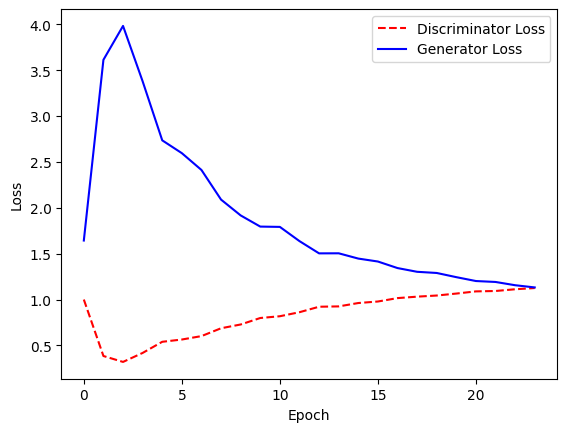

In [10]:
# Display loss graphic
import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss', linestyle='--', color='red')
plt.plot(g_losses, label='Generator Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

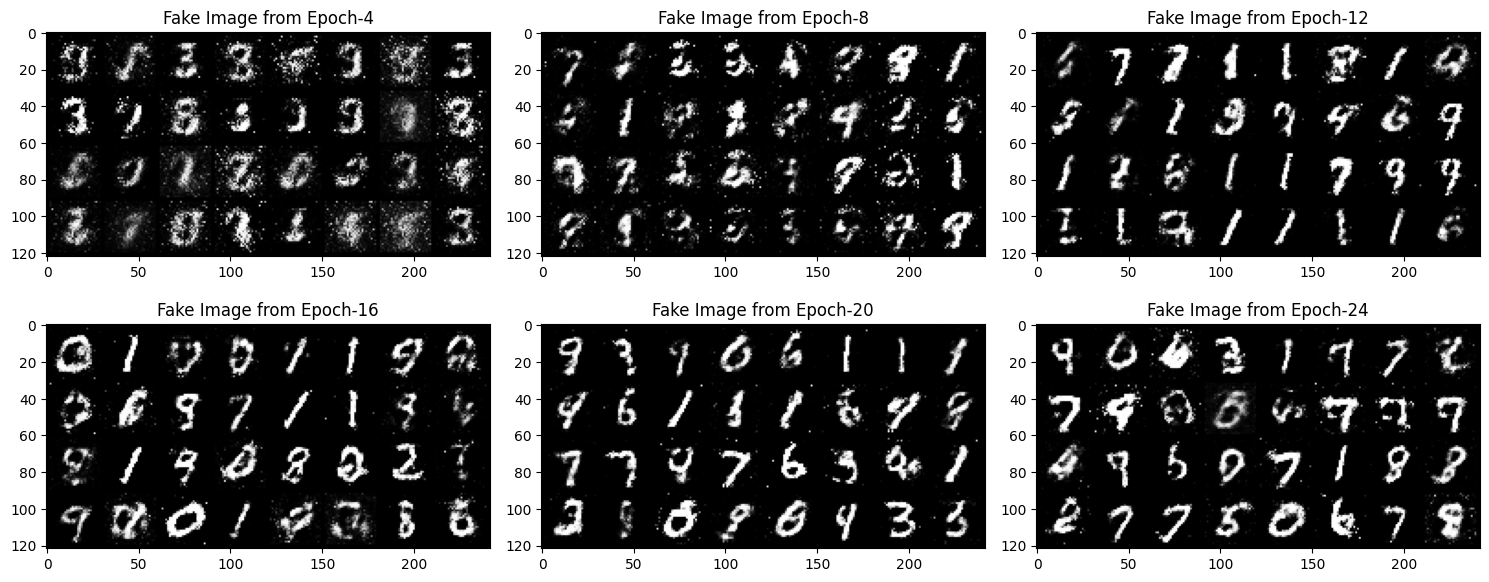

In [15]:
# Display fake images progress through epoch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

skip_num = 4

fig, ax = plt.subplots(num_epochs//(skip_num*3), 3, figsize=(15, 6))
ax = ax.ravel()

for i, epoch in enumerate(range(skip_num, num_epochs+skip_num, skip_num)):
    ax[i].imshow(Image.open(f"output/fake_images_epoch-{epoch}.png"))
    ax[i].set_title(f"Fake Image from Epoch-{epoch}")

fig.tight_layout()
plt.show()

In [12]:
# Save model
torch.save(G.state_dict(), "model/generator.pth")
torch.save(D.state_dict(), "model/discriminator.pth")

# Generate New Fake Image

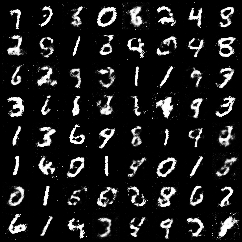

In [13]:
noise = torch.randn(64, 128).to(device)

fake_image = G(noise)
img_path = "output/new_fake_image.png"
save_image(fake_image.data, img_path, nrow=8, normalize=True)

IPImage(img_path)